## Physicochemical properties of wine and their impact on perceived quality

We review a wine quality dataset with physicochemical properties as features and a sensory variable (quality) as output.  There is no data about grape types, wine brand, wine selling price, etc.. The dataset is related to red variants of the Portuguese "Vinho Verde" wine.

The aim is to see which features have an impact on wine quality and to what extent.  For instance does acidity have a positive or negative impact on wine quality?

This dataset is also available from the UCI machine learning [repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) and in [Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

For more details on the dataset, consult the reference.  
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

#### Experimenting with a pep8 style checker

In [ ]:
!pip install pycodestyle pycodestyle_magic

In [ ]:
%load_ext pycodestyle_magic

In [ ]:
# example
%%pycodestyle
def square_of_number(
     num1, num2, num3, 
     num4):
    return num1**2, num2**2, num3**2, num4**2

### Read data

In [110]:
import pandas as pd
import os

# read data
source_directory = './source_data'
file_name = 'winequality-red.csv'
wine_df = pd.read_csv(os.path.join(source_directory, file_name))

In [473]:
# show first few rows
wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,pH_norm,chlorides_quantile,free sulfur dioxide_quantile,citric acid_quantile,alcohol_quantile,fixed acidity_quantile,residual sugar_quantile,volatile acidity_quantile,total sulfur dioxide_quantile,sulphates_quantile
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,1.288240,0.368421,0.333333,0.000000,0.111111,0.315789,0.200000,0.894737,0.421053,0.263158
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,-0.719708,0.842105,0.833333,0.000000,0.277778,0.473684,0.666667,1.000000,0.789474,0.684211
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,-0.331073,0.789474,0.500000,0.111111,0.277778,0.473684,0.466667,0.947368,0.684211,0.578947


In [474]:
wine_df.shape

(1599, 23)

In [113]:
# check for nan values
has_nans = set(wine_df.columns[wine_df.isnull().mean() != 0])
has_nans

set()

As we can see above, the dataset contains no nan values

### Visualize correlations between features

<AxesSubplot:>

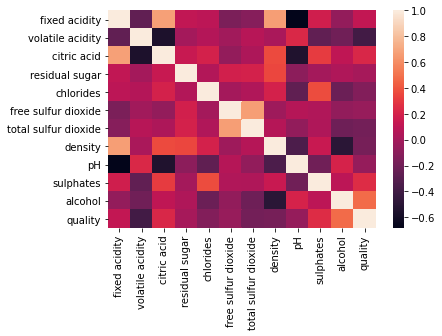

In [114]:
import seaborn as sns

sns.heatmap(wine_df.corr())

<AxesSubplot:>

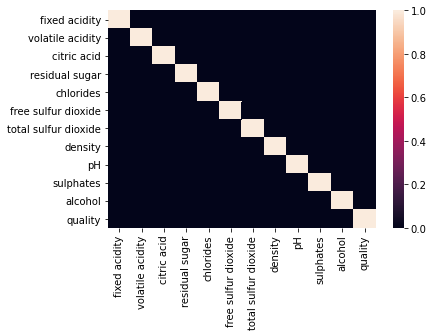

In [128]:
sns.heatmap(abs(wine_df.corr()) > 0.69)

Although some columns show correlations, I cannot see columns that have such a high degree of correlation that grant being dropped.  The highest degree of correlation, in absolute terms, is under 0.7.

### Visualize features distributions

Next, we want to visualize each feature's distribution to process the data and normalize or rescale.

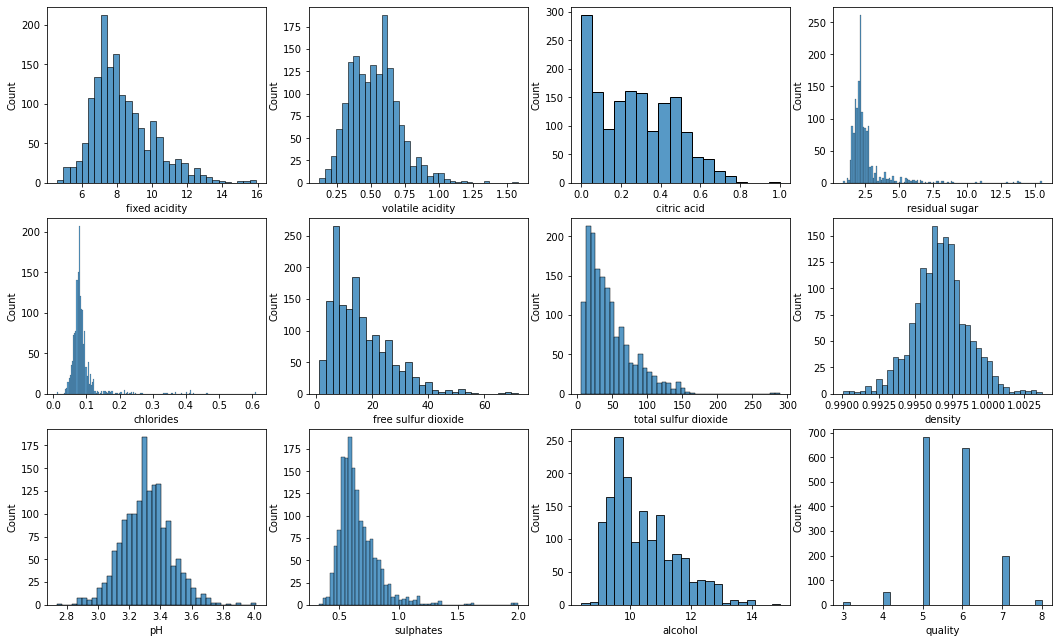

In [129]:
# plot data distributions to normalize or rescale

import seaborn as sns
import matplotlib.pyplot as plt

n_rows=3
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18,11))
for i, column in enumerate(wine_df.columns):
    sns.histplot(wine_df[column],ax=axes[i//n_cols,i%n_cols])

Both the density and pH features look Gaussian, so we normalize them using a z-score.  For the rest, we apply  a quantile transformation, since they don't conform to a particular distribution.

In [130]:
# save original column names for later
original_columns = wine_df.columns
original_columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [131]:
# normalize Gaussian distributions: density and pH
# its a Gaussian! So, use z-score to normalize the data
# density
wine_df['density_norm'] = (wine_df['density'] - wine_df['density'].mean()) / wine_df['density'].std()
# pH
wine_df['pH_norm'] = (wine_df['pH'] - wine_df['pH'].mean()) / wine_df['pH'].std()

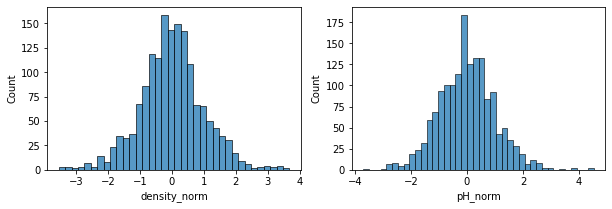

In [132]:
# visualize normalized distributions
n_rows=1
n_cols=2
gauss_cols = ['density_norm', 'pH_norm']
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,3))
for i, column in enumerate(gauss_cols):
    sns.histplot(wine_df[column], ax=axes[i])

In [134]:
wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,density_norm,pH_norm
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.558100,1.288240
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.028252,-0.719708
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.134222,-0.331073


We transform the rest of the features using quantiles, since they don't resemble any particular distribution. Then rescale to \[0,1\].

In [136]:
# list non gaussian columns to transform, remember to remove the already transformed columns.
# ignore the 'quality' columns since that is the target
non_gauss_cols = list(set(wine_df.columns) - set(['density', 'pH']) - set(gauss_cols) - set(['quality']))
non_gauss_cols

['chlorides',
 'free sulfur dioxide',
 'citric acid',
 'alcohol',
 'fixed acidity',
 'residual sugar',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates']

The number of quantiles, numQuantiles, is set as 20 somewhat arbitrarily.  Most of the quantile transformation code is taken from Google's clustering [tutorial](https://developers.google.com/machine-learning/clustering/prepare-data) and Colab [notebook](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/clustering/clustering-manual-similarity.ipynb?utm_source=ss-clustering&utm_campaign=colab-external&utm_medium=referral&utm_content=clustering-manual-similarity#scrollTo=ypMg6cVxW0Uq)

In [137]:
numQuantiles = 20
colsQuantiles = [col+'_'+'quantile' for col in non_gauss_cols]

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for col, col_q in zip(non_gauss_cols, colsQuantiles):
  wine_df[col_q] = createQuantiles(wine_df[col], numQuantiles)

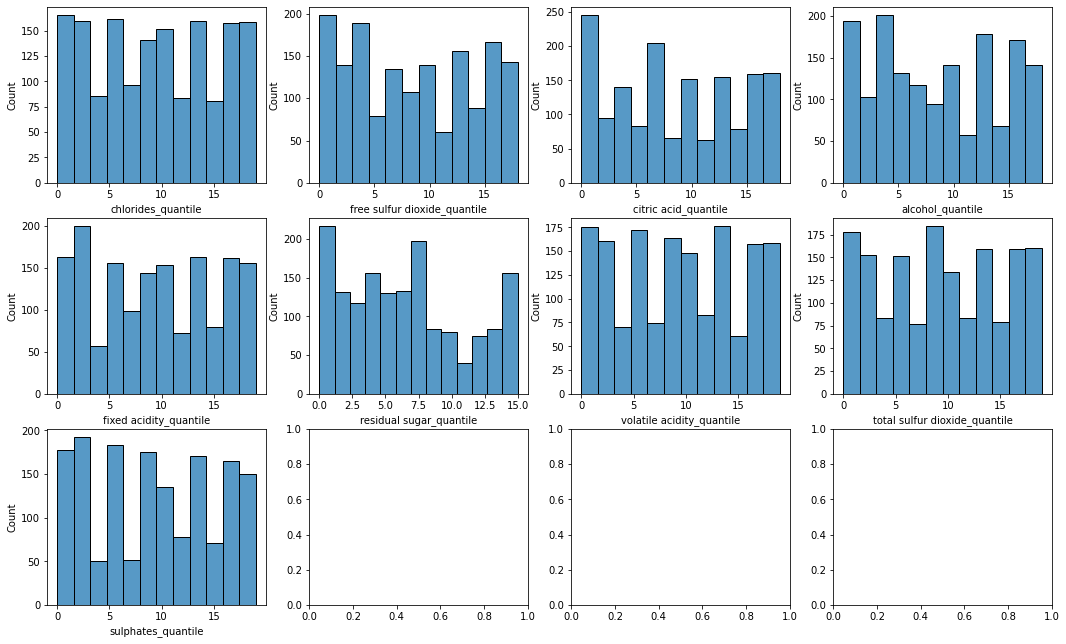

In [138]:
# visualize quantized columns before rescaling to [0,1]
n_rows=3
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18,11))
for i, column in enumerate(colsQuantiles):
    sns.histplot(wine_df[column],ax=axes[i//n_cols,i%n_cols])

In [139]:
# rescale non-gaussian columns to [0,1]
import numpy as np

def minMaxScaler(numArr):
    minx = np.min(numArr)
    maxx = np.max(numArr)
    numArr = (numArr - minx) / (maxx - minx)
    return numArr

for string in colsQuantiles:
    wine_df[string] = minMaxScaler(wine_df[string])

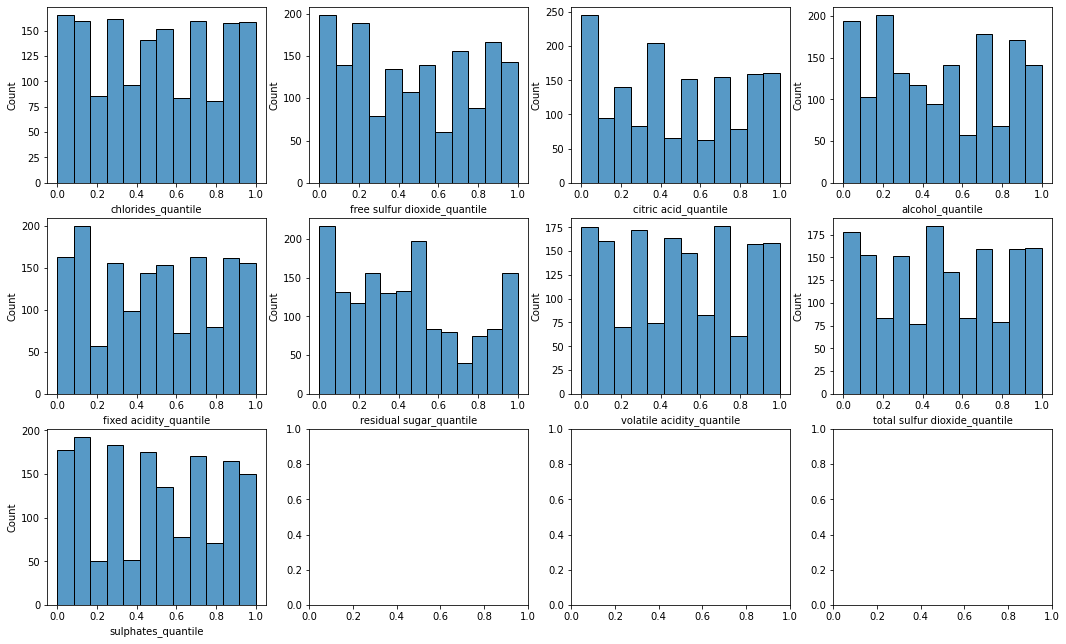

In [140]:
# visualize quantized columns after rescaling to [0,1]
n_rows=3
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18,11))
for i, column in enumerate(colsQuantiles):
    sns.histplot(wine_df[column],ax=axes[i//n_cols,i%n_cols])

In [141]:
wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,pH_norm,chlorides_quantile,free sulfur dioxide_quantile,citric acid_quantile,alcohol_quantile,fixed acidity_quantile,residual sugar_quantile,volatile acidity_quantile,total sulfur dioxide_quantile,sulphates_quantile
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,1.288240,0.368421,0.333333,0.000000,0.111111,0.315789,0.200000,0.894737,0.421053,0.263158
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,-0.719708,0.842105,0.833333,0.000000,0.277778,0.473684,0.666667,1.000000,0.789474,0.684211
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,-0.331073,0.789474,0.500000,0.111111,0.277778,0.473684,0.466667,0.947368,0.684211,0.578947


### Run regression on transformed data

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [439]:
# get transformed features and target variable
feature_columns = list(set(wine_df.columns) - set(original_columns))
X = wine_df[feature_columns]
y = wine_df['quality']

In [440]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [441]:
# fit
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
reg_model.score(X_train, y_train) # r2_score

0.36574023212273765

In [442]:
# run on test data
y_test_preds = reg_model.predict(X_test) 
r2_score(y_test, y_test_preds)

0.3590744987668143

In [443]:
mean_squared_error(y_test, y_test_preds)

0.4146943221721549

In [245]:
# 1.0 is the perfect score
r2_score(y_test, y_test)

1.0

The model only explains 36% of the data, which is not great.

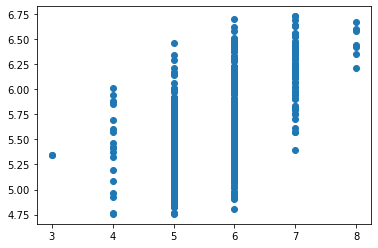

In [163]:
plt.scatter(y_test, y_test_preds)

What happens if we round the outputs?

In [167]:
# run on test data
r2_score(y_test, y_test_preds.round())

0.22211208787637515

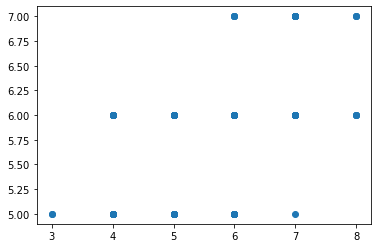

In [168]:
plt.scatter(y_test, y_test_preds.round())

Results are all over the place.  Let's regress without transforming and normalizing the features.

### Run regression with original data - no normalization nor quantization

In [171]:
# get original features and target variable
X = wine_df[original_columns].drop(columns=['quality'])
y = wine_df['quality']

In [173]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [174]:
# fit
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
reg_model.score(X_train, y_train) # r2_score

0.35632971309091943

In [175]:
# regress on test data
y_test_preds = reg_model.predict(X_test) 
r2_score(y_test, y_test_preds)

0.35944431072490635

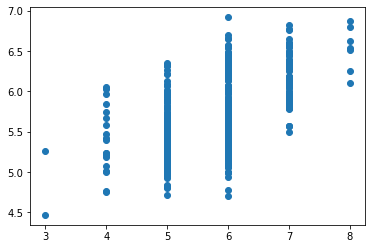

In [176]:
# view results
plt.scatter(y_test, y_test_preds)

As we can see, a linear regressor on physicochemical data does not seem to explain the quality variable very well. Let's try with an XGBoost model.

## Using XGBoost

XGBoost [docs](https://xgboost.readthedocs.io/en/latest/get_started.html)

### XGBoost regression

Using original features, no scaling.

In [193]:
# get original features and target variable
X = wine_df[original_columns].drop(columns=['quality'])
y = wine_df['quality']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [196]:
import xgboost as xgb
from math import sqrt

In [208]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.3,
    max_depth=6,                                                                    
    subsample=0.8,
    random_state=42
) 

mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
print("score: {0:,.2f}".format(rmse))

score: 0.64


/Users/andres/opt/miniconda3/envs/jupyter_sandbox_venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


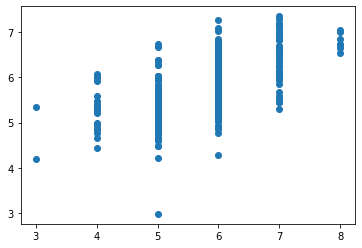

In [209]:
# visualize predictions
plt.scatter(y_test, predictions)

The results continue to be quite bad.  Let's now treat it as a classification problem.

### XGBoost classification

#### Using scaled features and a basic classifier

In [430]:
# use scaled features and target variable
feature_columns = list(set(wine_df.columns) - set(original_columns))
X = wine_df[feature_columns].drop(columns=['fixed acidity_quantile', 
                                           'free sulfur dioxide_quantile'])
y = wine_df['quality'] - 3 # rescale to 0 as min

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [431]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier(objective='multi:softprob', num_class=6, use_label_encoder=False)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
#preds = xgb_cl.predict_proba(X_test)
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

[08:02:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andres/opt/miniconda3/envs/jupyter_sandbox_venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.6723484848484849

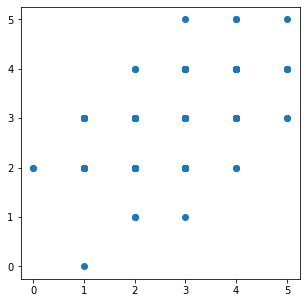

In [438]:
# visualize predictions
plt.figure(figsize=(5, 5))
plt.scatter(y_test, preds)

In [433]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.655686


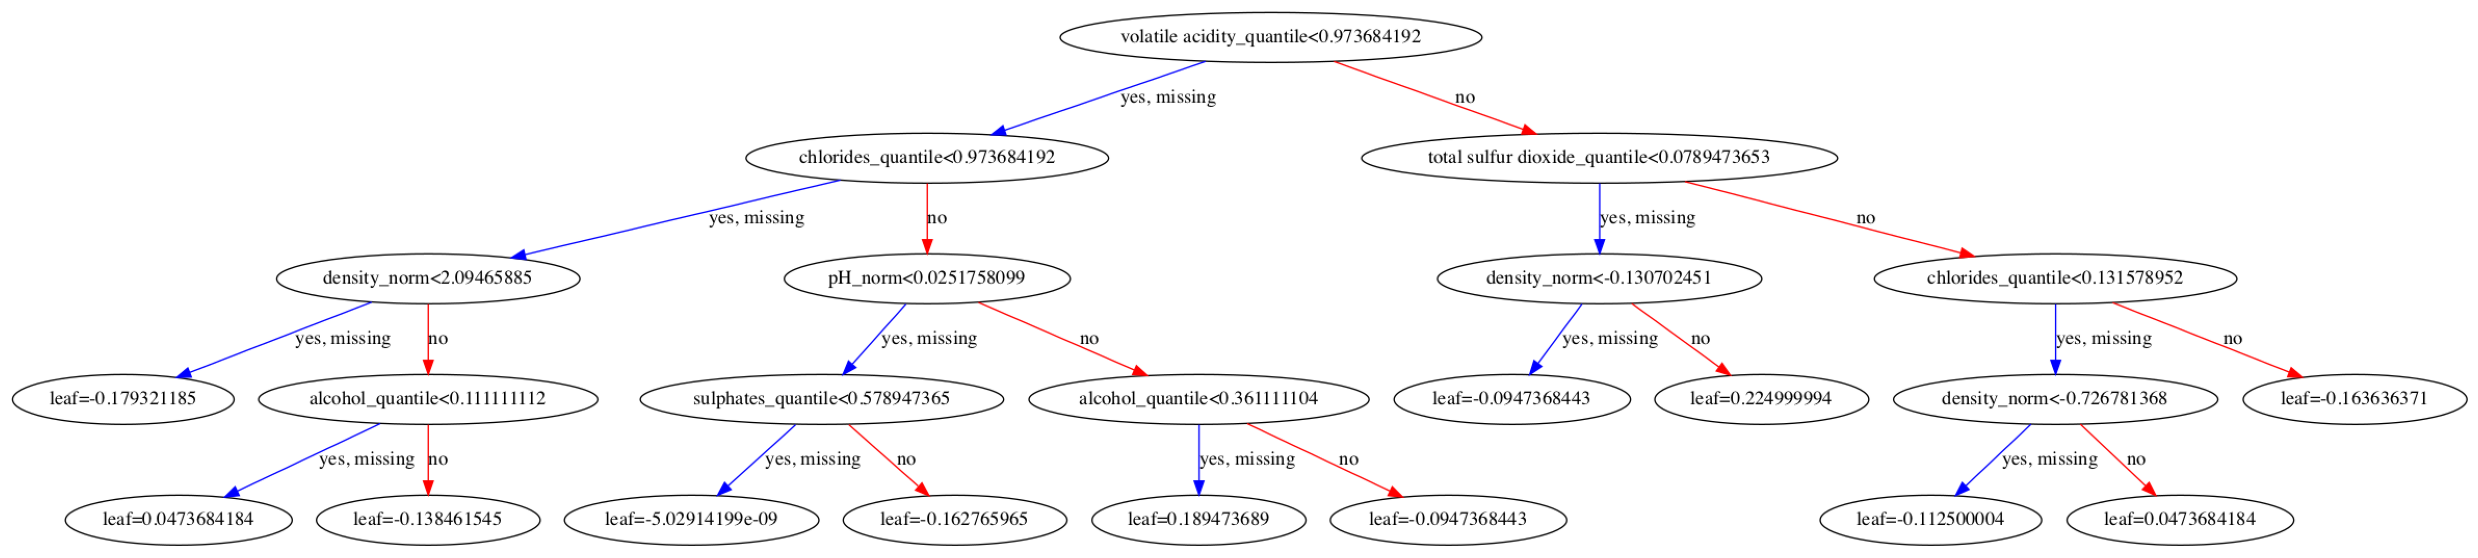

In [429]:
xgb.plot_tree(xgb_cl,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

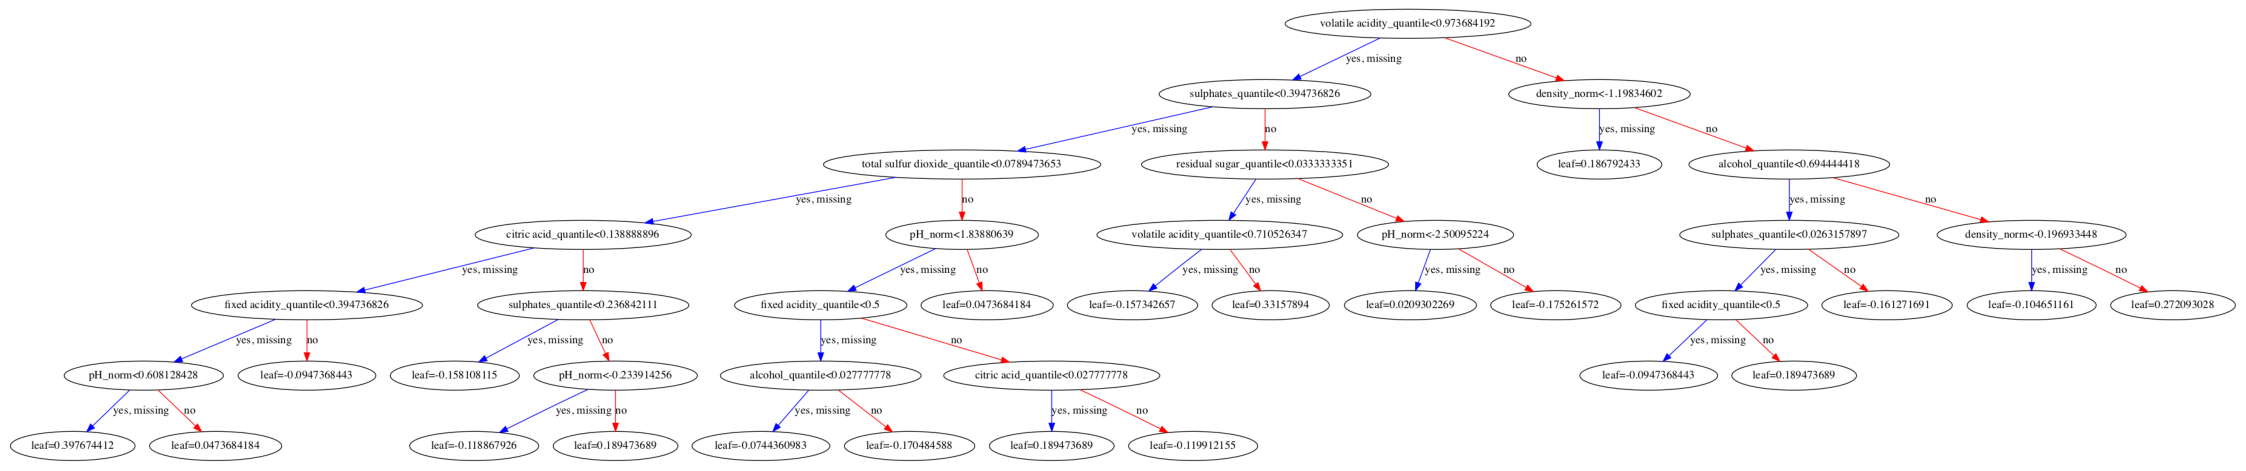

In [238]:
xgb.plot_tree(xgb_cl,num_trees=1)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

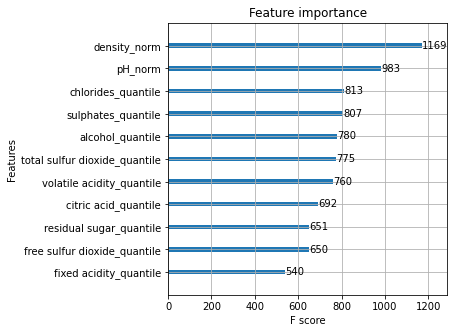

In [409]:
# feature importance
xgb.plot_importance(xgb_cl)
plt.rcParams['figure.figsize'] = [3, 3]
plt.show()

In [410]:
import sklearn.metrics
sklearn.metrics.roc_auc_score(y_test, preds, multi_class='ovo')

0.814488928613045

### ROC curves

In [371]:
from sklearn.preprocessing import label_binarize
y_train = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5])
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_train.shape[1]
n_classes

6

In [372]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
y_score = preds
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [374]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

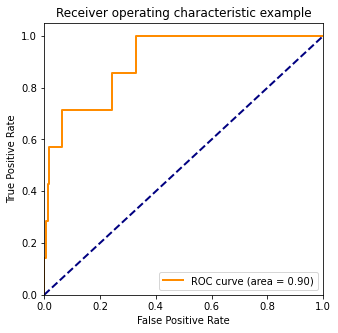

In [385]:
plt.figure()
lw = 2
class_num=5
plt.plot(fpr[class_num], tpr[class_num], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_num])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

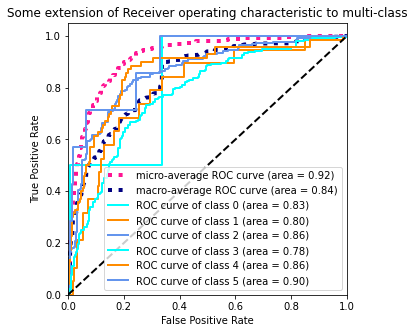

In [389]:
from numpy import interp
from itertools import cycle

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [391]:
y.value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

## Using a deep learning model

In [446]:
# compare scaling methods for mlp inputs on regression problem
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import mean
from numpy import std

# prepare dataset with input and output scalers, can be none
def get_dataset(input_scaler, output_scaler):
    # generate dataset
	X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	# scale inputs
	if input_scaler is not None:
		# fit scaler
		input_scaler.fit(trainX)
		# transform training dataset
		trainX = input_scaler.transform(trainX)
		# transform test dataset
		testX = input_scaler.transform(testX)
	if output_scaler is not None:
		# reshape 1d arrays to 2d arrays
		trainy = trainy.reshape(len(trainy), 1)
		testy = testy.reshape(len(trainy), 1)
		# fit scaler on training dataset
		output_scaler.fit(trainy)
		# transform training dataset
		trainy = output_scaler.transform(trainy)
		# transform test dataset
		testy = output_scaler.transform(testy)
	return trainX, trainy, testX, testy

# fit and evaluate mse of model on test set
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='linear'))
	# compile model
	model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate the model
	test_mse = model.evaluate(testX, testy, verbose=0)
	return test_mse

# evaluate model multiple times with given input and output scalers
def repeated_evaluation(input_scaler, output_scaler, n_repeats=30):
	# get dataset
	trainX, trainy, testX, testy = get_dataset(input_scaler, output_scaler)
	# repeated evaluation of model
	results = list()
	for _ in range(n_repeats):
		test_mse = evaluate_model(trainX, trainy, testX, testy)
		print('>%.3f' % test_mse)
		results.append(test_mse)
	return results

# unscaled inputs
results_unscaled_inputs = repeated_evaluation(None, StandardScaler())
# normalized inputs
results_normalized_inputs = repeated_evaluation(MinMaxScaler(), StandardScaler())
# standardized inputs
results_standardized_inputs = repeated_evaluation(StandardScaler(), StandardScaler())
# summarize results
print('Unscaled: %.3f (%.3f)' % (mean(results_unscaled_inputs), std(results_unscaled_inputs)))
print('Normalized: %.3f (%.3f)' % (mean(results_normalized_inputs), std(results_normalized_inputs)))
print('Standardized: %.3f (%.3f)' % (mean(results_standardized_inputs), std(results_standardized_inputs)))
# plot results
results = [results_unscaled_inputs, results_normalized_inputs, results_standardized_inputs]
labels = ['unscaled', 'normalized', 'standardized']
pyplot.boxplot(results, labels=labels)
pyplot.show()

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`